<h2> Crop Classification through Multi-spectral imagery and Self Organizing Maps (SOM) </h2>

This notebook will make use of the spectral signatures of various crops to cluster crops by using an Artificial Neural Network and Self Organizing Maps.
First the multi-spectral Sentinel-2 data will be loaded and the pixel values will be pooled, to reduce calculation time. Then Then each pixel will be converted into a vector representing the spectral signatures for the 9 bands in use (Band 1 to 9). </br>
After that the approach of Self Organizing maps using Artificial Neural Networks will be implemented to perform and unsupervised cluster analysis for these vectors and group similar spectal signatures. Lastly the clusters will be compared to the library of spectral signatures in order to find out which crop the clusteres fields are actually growing.

In [1]:
# necessary Imports
import os
import numpy as np 
import geojson
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import matplotlib.cm as cm
from IPython.display import Image
from skimage import measure

from helper_functions import RasterHelper

# geodata specific imports
import gdal
import rasterio
from rasterio.mask import mask
from geojson import Polygon


Bad key "text.kerning_factor" on line 4 in
C:\Users\work\Anaconda3\envs\ml_az\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
with open('sample_data/Breda_NL/breda_AOI.geojson') as f:
    gj = geojson.load(f)

aoi = [Polygon(gj['features'][0]['geometry']['coordinates'])]


In [3]:
# aoi NorthDakota
# set aoi for clipping sentinel data and Labels to same extent
aoi= [{'type': 'Polygon', 'coordinates': [[[-10821406, 6029867], [-10821406, 6067979], [-10768297, 6067979], [-10768297, 6029867], [-10821406, 6029867]]]}]

<h3> Open the Sentinel-2 data </h3>

In this step the raster bands for three times of the year for a region in the Netherlands (surrounding the city of Breda) will be loaded. Included is the pool of the bands to a max value in each 3x3 kernel. This way the amount of pixels can be reduced, while preserving the main image features. Additionally the bands will ne normalized and written into an array containing all data

In [10]:
# open data sets
helper = RasterHelper()
directory = "sample_data/NorthDakota/Sentinel/"
# loop over directory and open all single band tiffs

multiband_array = helper.open_multiband_scene(directory, aoi, pooling=True)


Files were loaded sucessfully. 


<h3> Example band</h3>
The image below shows the refelctance near infra red for the scene taken in May of 2017

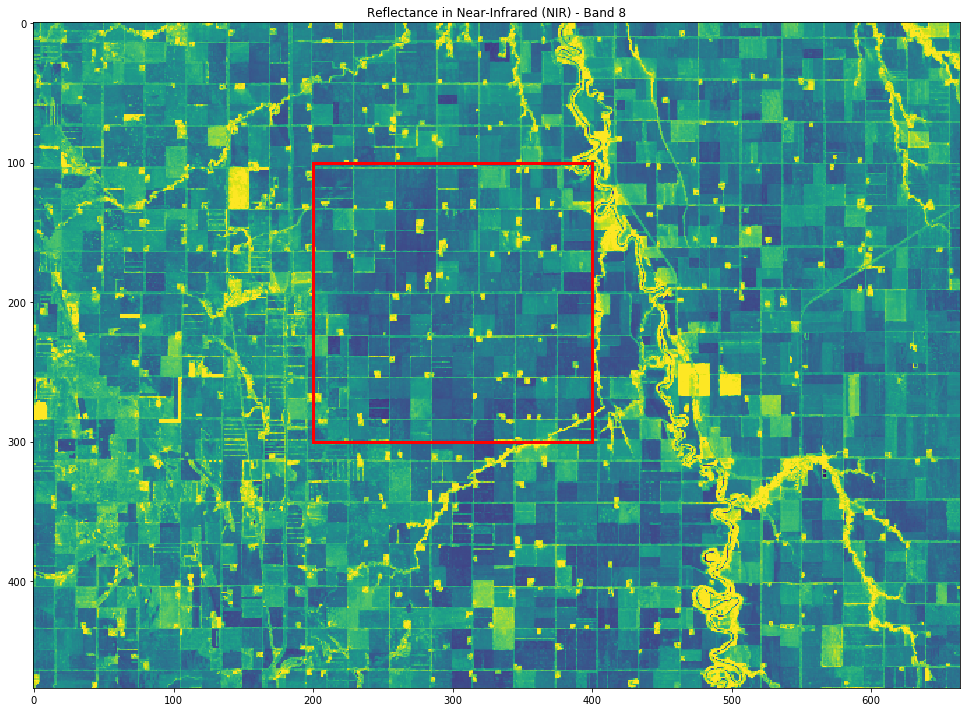

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(multiband_array[0][7])
ax.set_title("Reflectance in Near-Infrared (NIR) - Band 8")
rect = patches.Rectangle((200,100), 200, 200, linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.tight_layout()

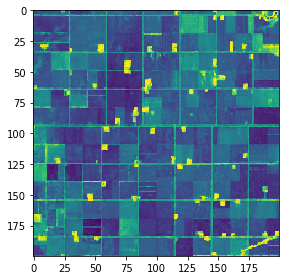

In [14]:
# reduce extent to smaller region
small_array = []

for multiband in multiband_array:
    month = []

    for array in multiband:

        cutout = array[100:300, 200:400]
        month.append(cutout)

    small_array.append(month)

small_array= np.array(small_array)
plt.imshow(small_array[0][7])
plt.tight_layout()

    

<h3> Spectral Signature for single pixels </h3>

Looking into all 9 Bands for each pixel, the spectral signature of refelctance can be derived and display as a graph. below a sample of 200 pixels is displayed. The goal is to cluster these signatures to detect the unterlying crops grown in that pixel

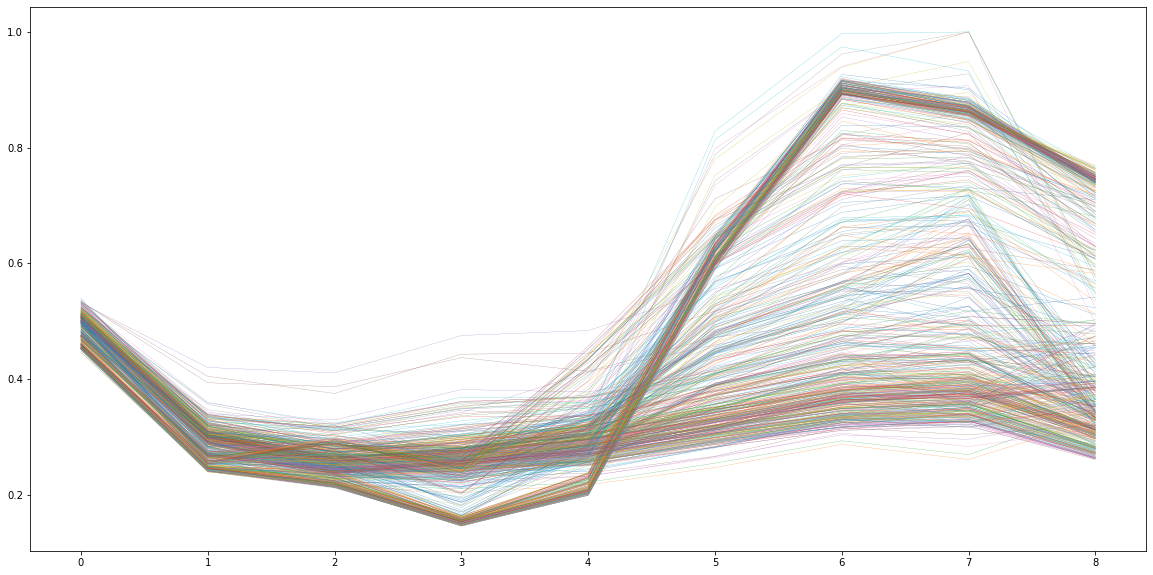

In [15]:
sig = []
fig, ax = plt.subplots(figsize=(20, 10))
for array in small_array:
    for k in range(30):
        for j in range(10):
            sig = ([i[k][j] for i in array])
            ax.plot(np.array(range(9)), sig, linewidth=0.2)

<h2> Self Organising Maps (SOM)</h2>

Making use of self organizing maps, allws to cluster the data based on their verctors. In this case on vector will consists of the concatenated vectors of three time steps within the year (May, August, November) to als inculde the plants phenology isntead of only looking at a snap shot of a single month. By combing the vectors, a vector of 27 varibales will be created for each pixel.

In [16]:
import pandas as pd

In [17]:

june = small_array[0].T.reshape(-1,9)
september = small_array[1].T.reshape(-1,9)
#november = small_array[2].T.reshape(-1,9)


In [18]:
small_array[0][0].shape

(200, 200)

In [19]:
df_1 = pd.DataFrame(june, columns=['1_1','1_2','1_3','1_4','1_5','1_6','1_7','1_8','1_9'])
df_2 = pd.DataFrame(september, columns=['2_1','2_2','2_3','2_4','2_5','2_6','2_7','2_8','2_9'])
#df_3 = pd.DataFrame(november, columns=['3_1','3_2','3_3','3_4','3_5','3_6','3_7','3_8','3_9'])

df = pd.concat([df_1, df_2], axis=1)

In [20]:
# data frame containing vectors for all pixels
df.head()

1_1       1_2       1_3       1_4       1_5       1_6       1_7  \
0  0.496785  0.293004  0.248249  0.248493  0.296498  0.446998  0.515755   
1  0.506790  0.306996  0.260502  0.265751  0.297993  0.435492  0.486000   
2  0.509995  0.337255  0.295003  0.321248  0.330251  0.446006  0.520500   
3  0.509646  0.337743  0.310750  0.309255  0.358495  0.550256  0.639002   
4  0.508556  0.309499  0.289754  0.274250  0.342245  0.530251  0.619257   

        1_8       1_9       2_1       2_2       2_3       2_4       2_5  \
0  0.583001  0.321456  0.491289  0.289250  0.251743  0.262501  0.254002   
1  0.525505  0.323798  0.486114  0.283253  0.240253  0.246250  0.239750   
2  0.573754  0.341817  0.486860  0.264256  0.223499  0.214755  0.243000   
3  0.643748  0.355511  0.499808  0.277501  0.247501  0.237507  0.289494   
4  0.676493  0.351616  0.498339  0.306493  0.297749  0.262745  0.307744   

        2_6       2_7       2_8       2_9  
0  0.311498  0.358495  0.336248  0.366565  
1  0.283253  0.330999  0.316243  0.353820  
2  0.280995  0.329503  0.325002  0.357290  
3  0.455497  0.524743  0.582254  0.433902  
4  0.480751  0.569497  0.595499  0.510444

<h2> Sample of combined vectors </h2>

Similar to the spectral signature avove, this graphe contains the refelctance for each of the 9 bands for a sample of pixels. But in this case the three time steps where joined together to form on vector per pixel over the whole yeare. So we have 9 bands at 3 time steps resulting in a vector of length 27.

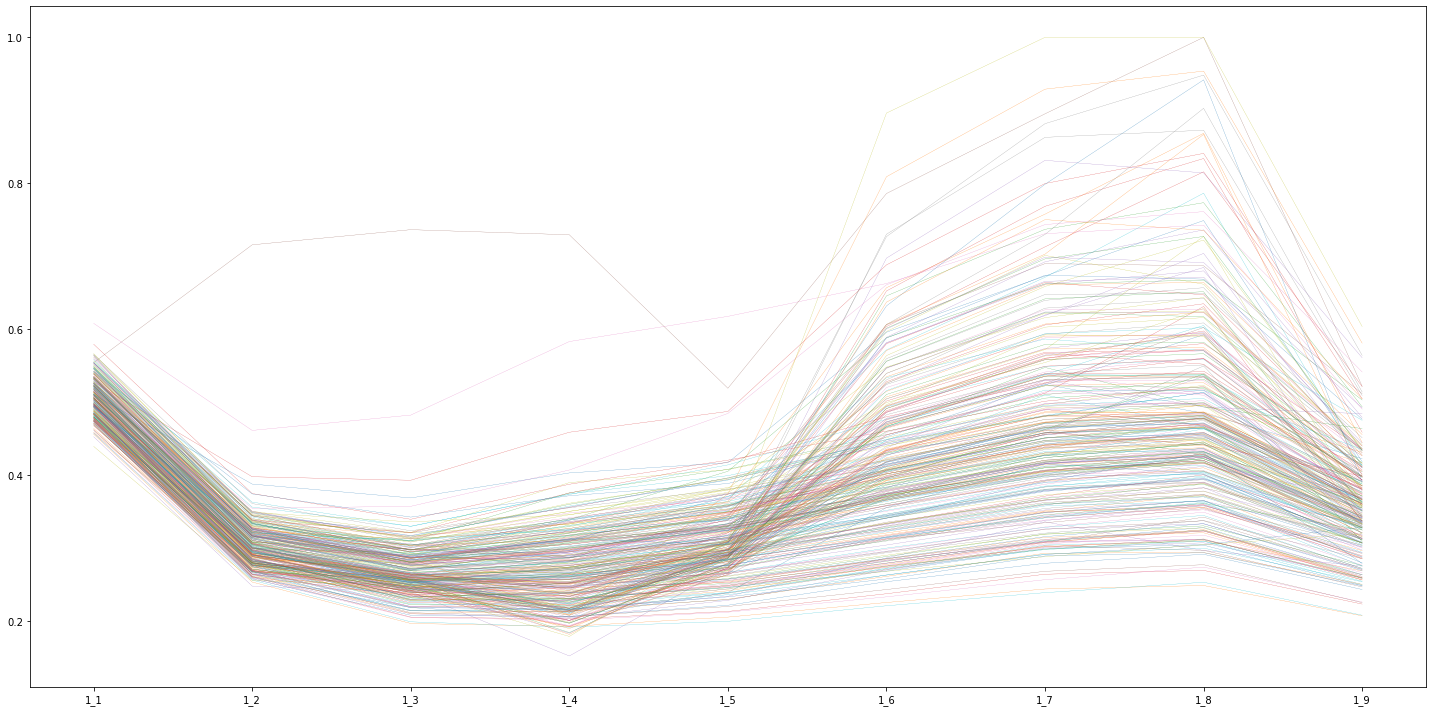

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_1.sample(n=300).T, linewidth=0.2)
plt.tight_layout()

In [68]:
#df.to_csv("sample_data/crop_data.csv", index=False)

<h2> Train Self Organizing Map </h2>

In [22]:
import SimpSOM as sps
from sklearn.cluster import KMeans


By training the model, the vetory will be put into bins of similarity. The more similar  bins are to each other, the closer they are in the hexagonal map blow. Because this method describes a competitive and unsupervised approach. the bins are "fighting" to get as many vectors as possible. They do so by slightly adjusting their values match the incoming vectors. This way each iterations the clusters will become clearer in structure and the final similarity of vectors in each variable can be derived from the outcome hexagonal maps representing the distribution of each variable</h2>

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!


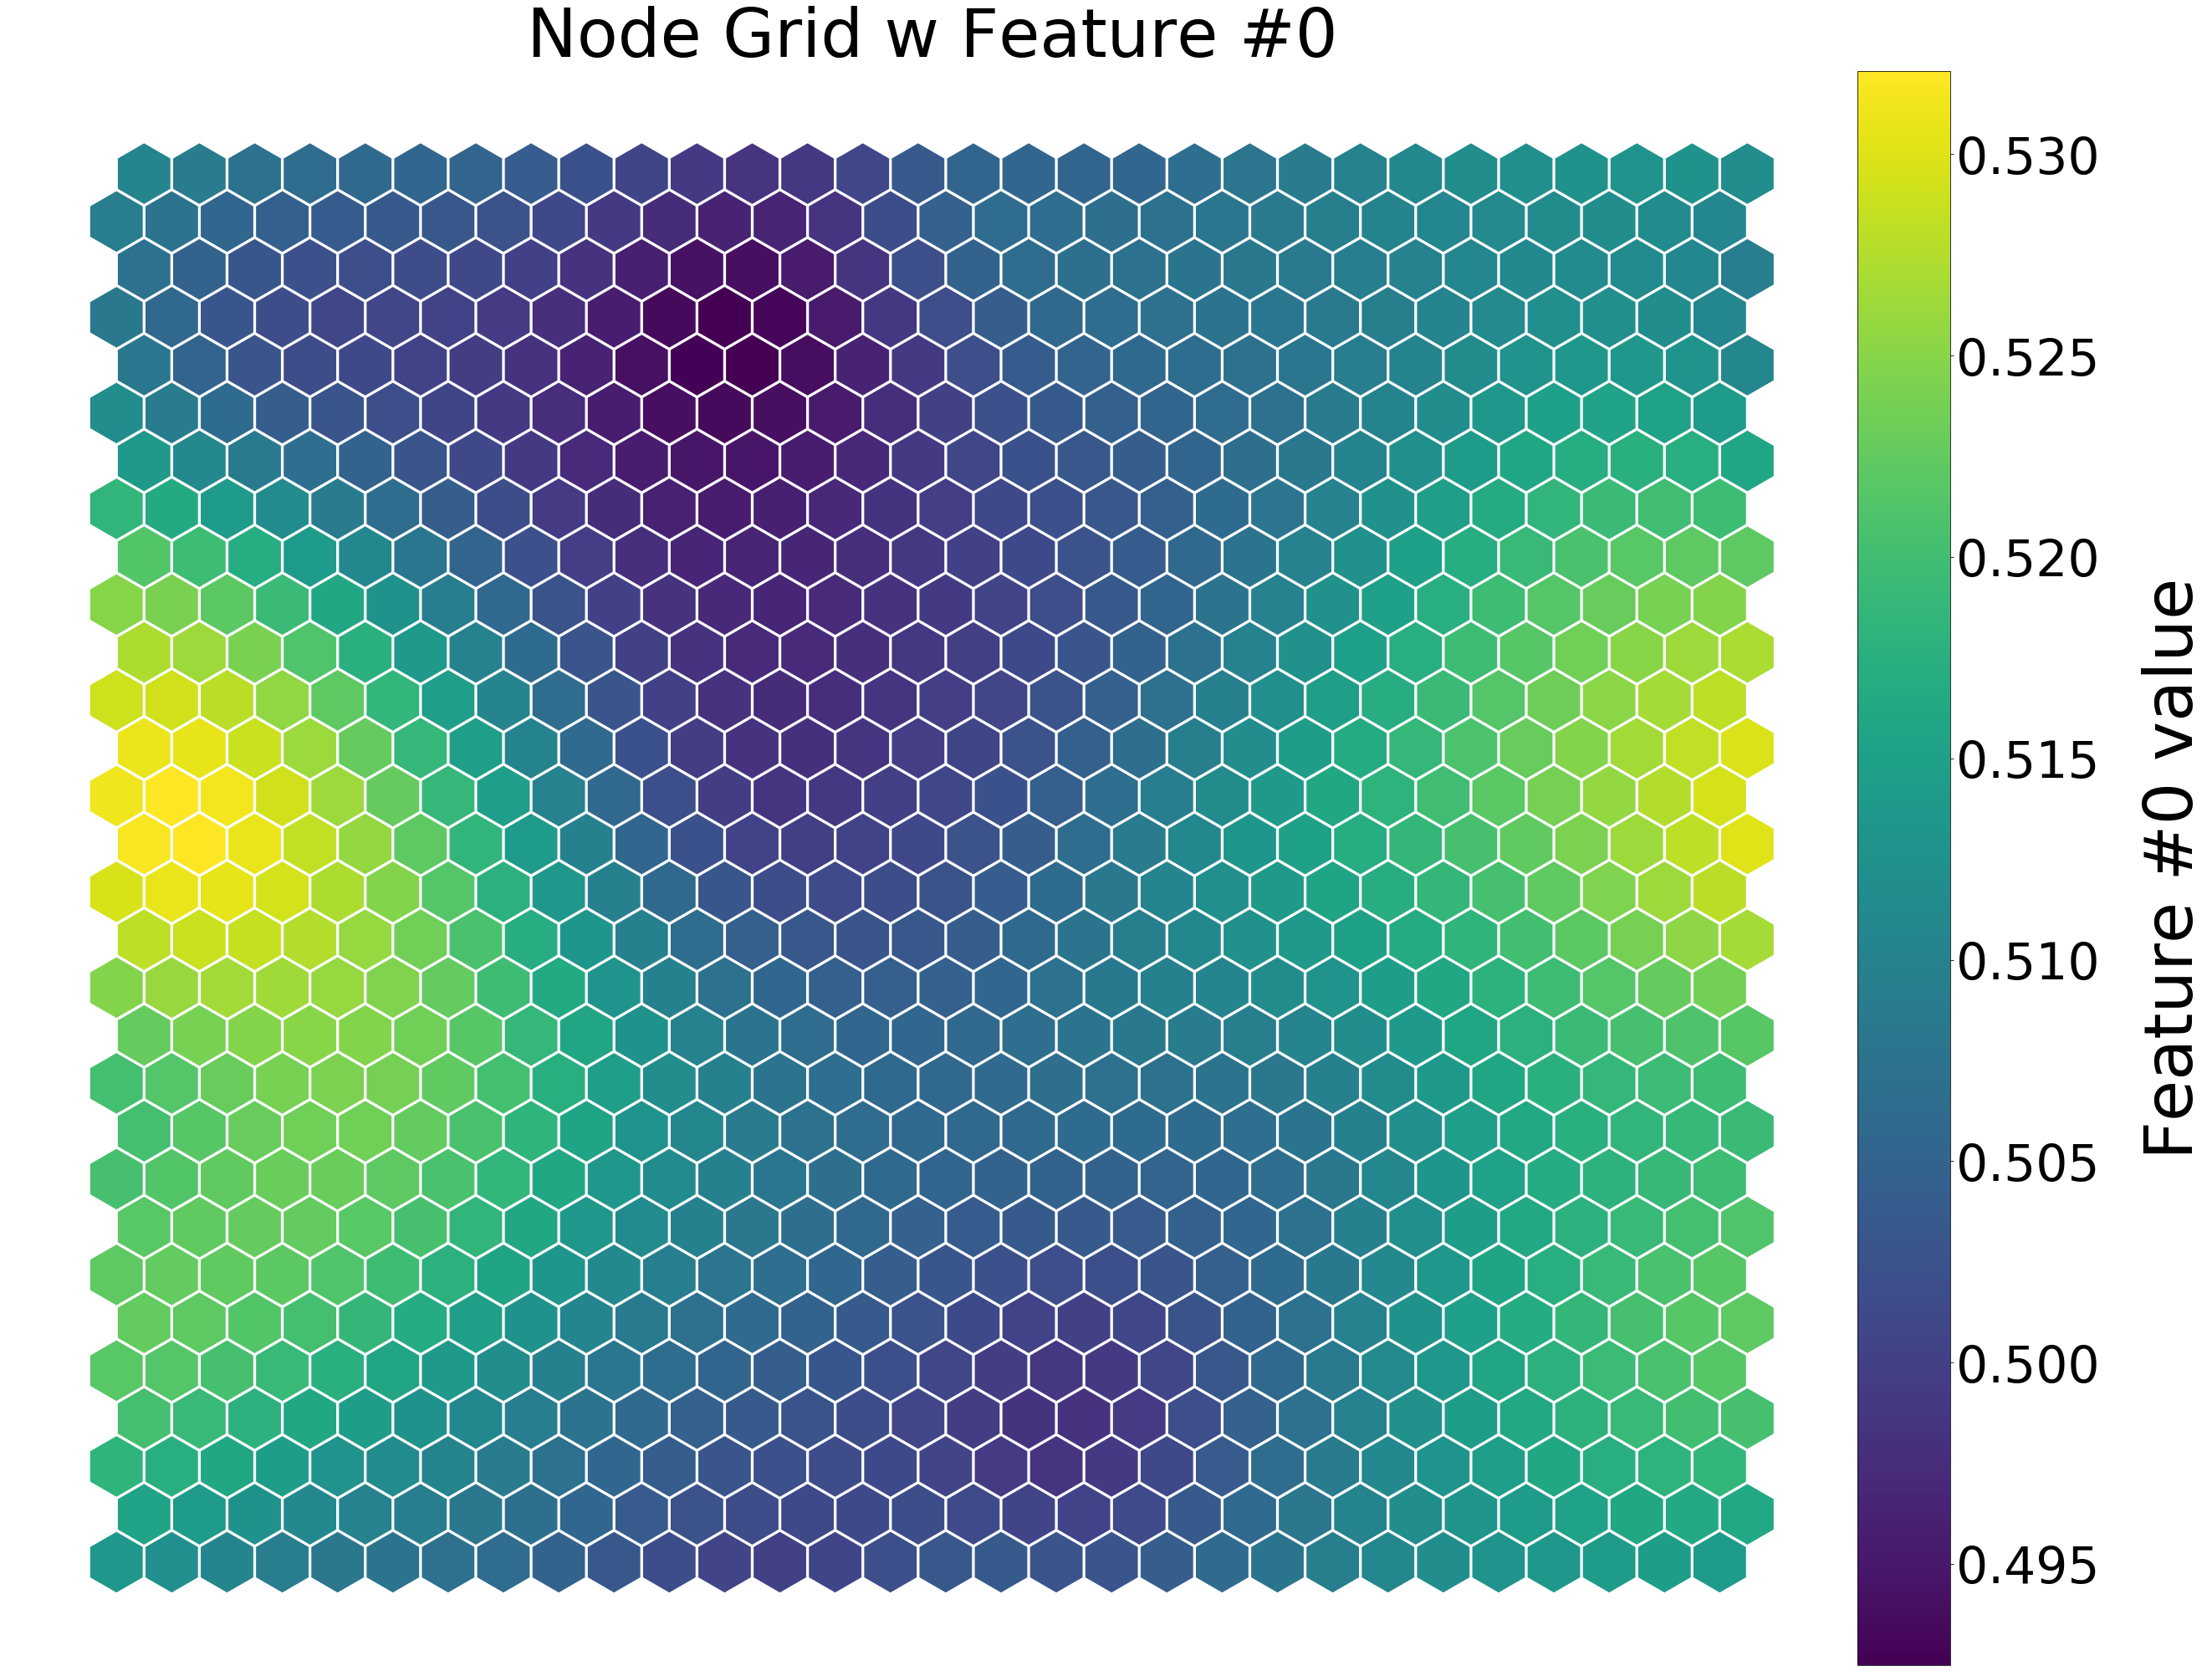

In [23]:
#sample_df = df.sample(n = 10000) 
train = np.array(df)
net = sps.somNet(30, 30, train, PBC=True)
net.train(0.01, 5000)
net.save('filename_weights')
net.nodes_graph(colnum=0)

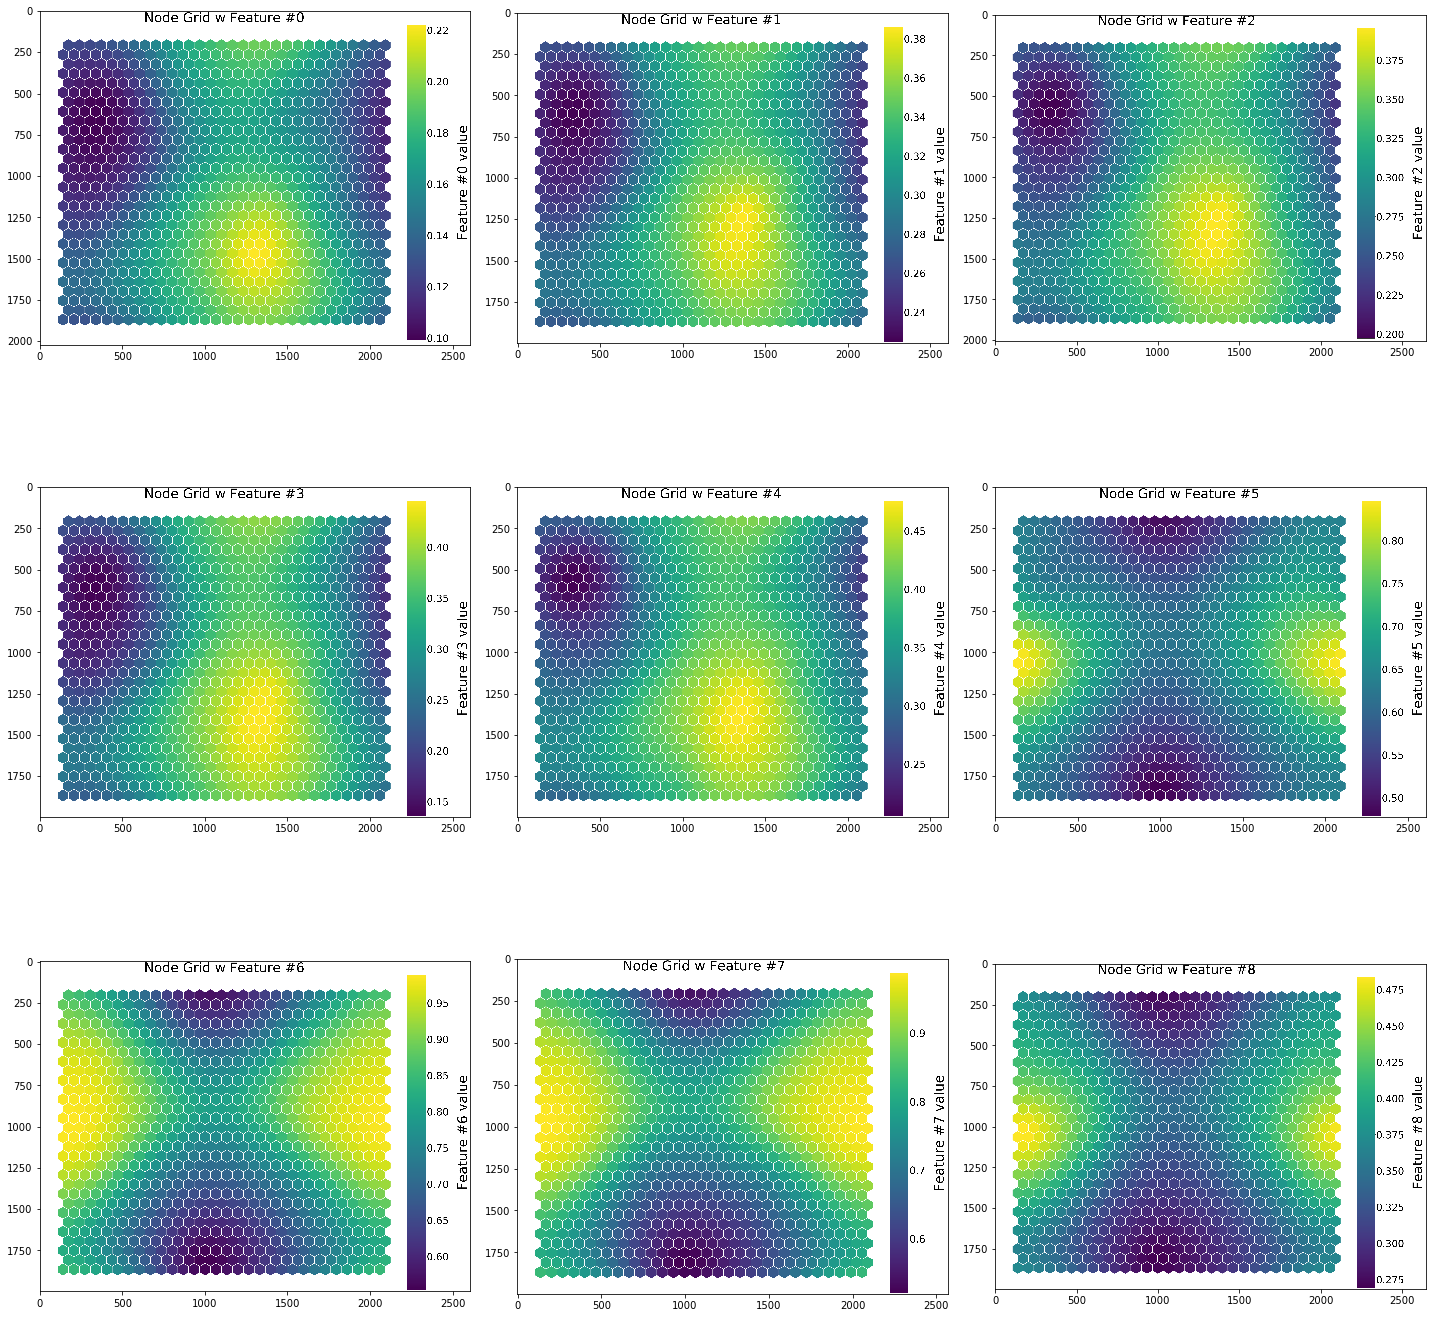

In [87]:
from matplotlib.image import imread
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

fig.subplots_adjust(hspace=0.5)

for ax, num in zip(axes.flatten(), [i for i in range(10)]):
    im = imread("plots/nodesFeature_"+str(num)+".png")
    ax.imshow(im)

plt.tight_layout()

By comparing the binned heatmap for each variable the correlation between variabels can be inspected. Variables showing the same distribution are strongly positivly correlated,  opposite maps show negative correlation. A very noisy heatmap would represent a variable, which has no influence on the binning.



<h3> Cluster Feature Map </h3>
In order to generate the clusters representing different vegetation, the data will be projected onto the feature maps and clusters will be formed using KMeans clustering. This way pixels in close proximity in the SOM, which means high levels of similiary will be clustered by their, newly introduced spatial relationship of lying in neighbouring bins. the Cluster Id for each pixel can then be added to the input data. to restore the image

In [24]:
# project data points on the SOM
prj = net.project(train)
True

True

<Figure size 432x288 with 0 Axes>

In [25]:
prj = np.array(prj)

In [26]:
# use K-menas clustering to cluster bins
kmeans = KMeans(n_clusters=6, random_state=0).fit(prj)
df['clusters']=kmeans.labels_

In [27]:
# data frame with cluster ID
df.head()

1_1       1_2       1_3       1_4       1_5       1_6       1_7  \
0  0.496785  0.293004  0.248249  0.248493  0.296498  0.446998  0.515755   
1  0.506790  0.306996  0.260502  0.265751  0.297993  0.435492  0.486000   
2  0.509995  0.337255  0.295003  0.321248  0.330251  0.446006  0.520500   
3  0.509646  0.337743  0.310750  0.309255  0.358495  0.550256  0.639002   
4  0.508556  0.309499  0.289754  0.274250  0.342245  0.530251  0.619257   

        1_8       1_9       2_1       2_2       2_3       2_4       2_5  \
0  0.583001  0.321456  0.491289  0.289250  0.251743  0.262501  0.254002   
1  0.525505  0.323798  0.486114  0.283253  0.240253  0.246250  0.239750   
2  0.573754  0.341817  0.486860  0.264256  0.223499  0.214755  0.243000   
3  0.643748  0.355511  0.499808  0.277501  0.247501  0.237507  0.289494   
4  0.676493  0.351616  0.498339  0.306493  0.297749  0.262745  0.307744   

        2_6       2_7       2_8       2_9  clusters  
0  0.311498  0.358495  0.336248  0.366565         3  
1  0.283253  0.330999  0.316243  0.353820         3  
2  0.280995  0.329503  0.325002  0.357290         3  
3  0.455497  0.524743  0.582254  0.433902         0  
4  0.480751  0.569497  0.595499  0.510444         0

<h3> Restore image with clusters</h3>

In [49]:
clusters = np.reshape(np.array(df["clusters"]), (200,200))
cluster_img = np.flip(np.rot90(clusters, 3), 1)

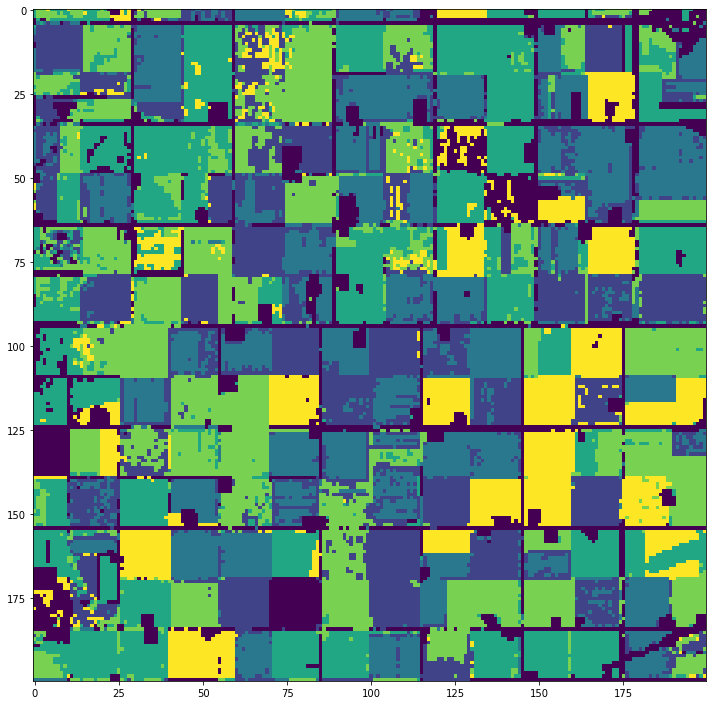

In [50]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.imshow(cluster_img)
plt.tight_layout()


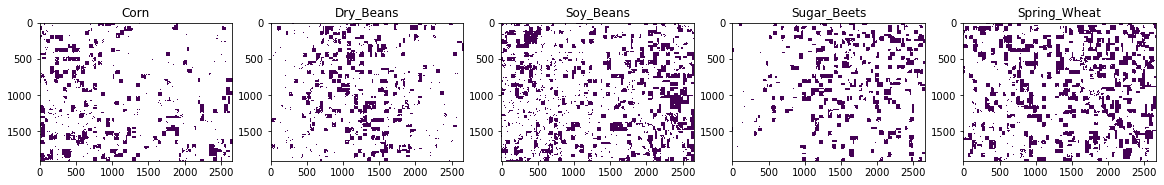

In [44]:
croplist = ["Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]
crop_arrays = []
fig, axes = plt.subplots(1,5, figsize = (20,5))
for i, crop in enumerate(croplist):
    raster = rasterio.open(f'sample_data/NorthDakota/classification/{crop}_3857.tif')

    out_img, out_transform = mask(raster, shapes=aoi, crop=True)
    array = out_img[0]
    array = np.where(array == 0, np.nan, array)
    array = np.where(array == np.nanmean(array), i+1, np.nan)
    crop_arrays.append(array)
    axes[i].imshow(array)
    axes[i].set_title(croplist[i])


crop_array = np.array(crop_arrays)

In [51]:
cropsum = np.nansum(crop_array, axis=0)
#cropsum = measure.block_reduce(cropsum, (4,4), np.max)


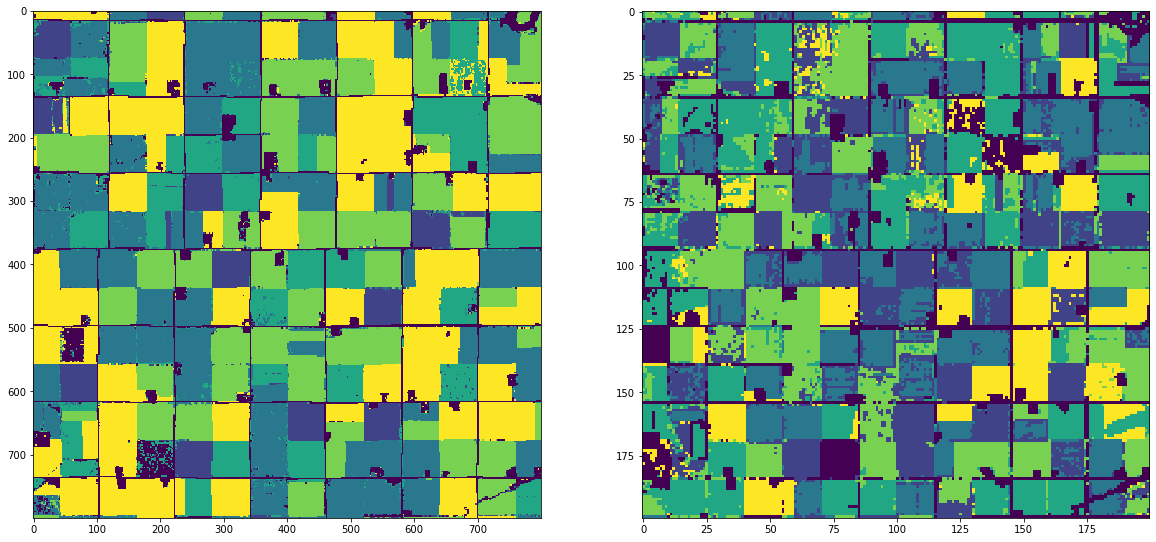

In [53]:
fix ,axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(cropsum[400:1200, 800:1600])
axes[1].imshow(cluster_img)

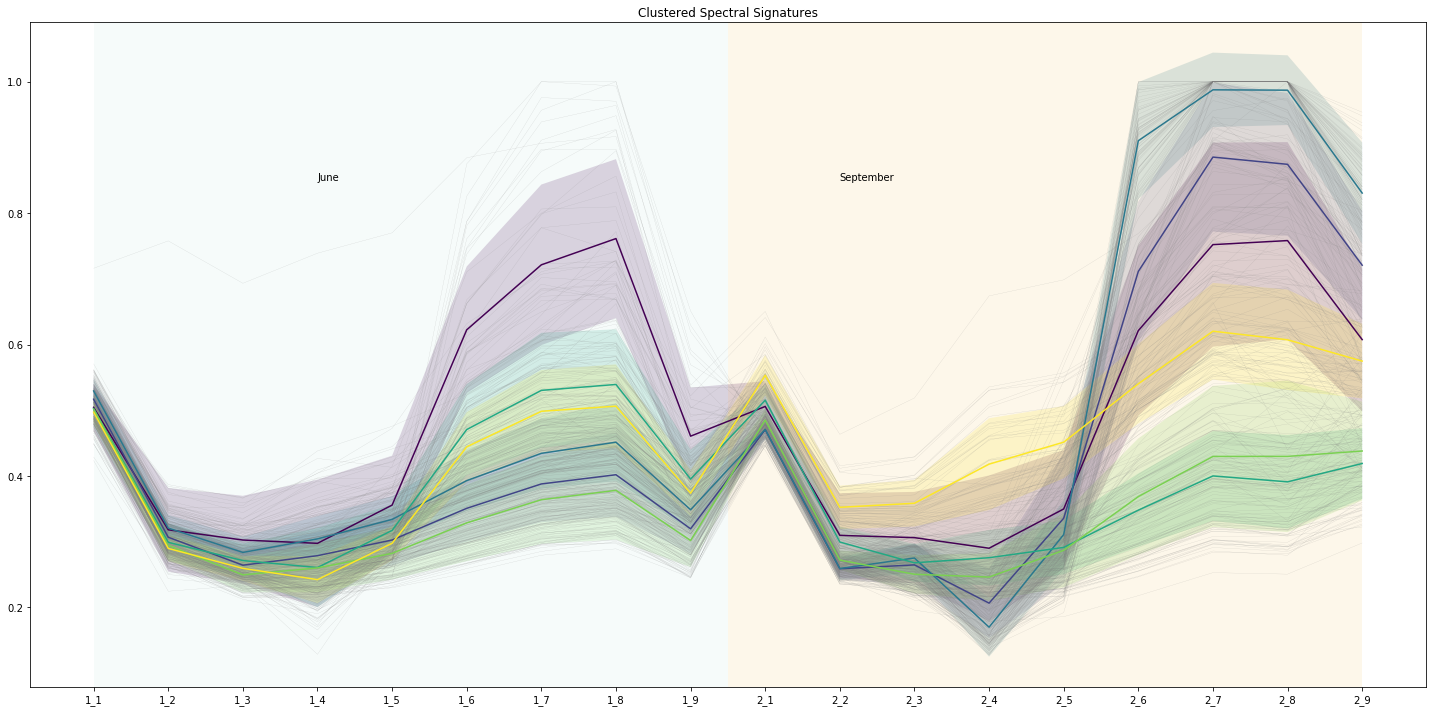

In [89]:
from matplotlib import cm
from helper_functions import LegendHelper


legend_helper = LegendHelper()


fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.drop(["clusters"], axis=1).sample(n=300).T, linewidth=0.2, c="gray", alpha=0.4)


for i in range(0,6):
    cluster = df[df["clusters"] == i].drop(["clusters"], axis=1)
    cluster = np.array(cluster)
    mean = np.mean(cluster, axis=0)
    sigma = cluster.std(axis=0)
    ax.plot(range(18), mean,  c=cm.viridis(i/5))
    ax.fill_between(range(18), mean+sigma, mean-sigma, facecolor=cm.viridis(i/5), alpha=0.2)

ax.axvspan(0, 8.5, facecolor='#d4ebe7', alpha=0.2)
ax.axvspan(8.5, 17, facecolor='#f7d998', alpha=0.2)
ax.text(3,0.85, "June")
ax.text(10,0.85, "September")
plt.title("Clustered Spectral Signatures")
plt.tight_layout()
plt.savefig("plots/clustered_signatures.png")